In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(knitr)
library(stringr)
library(DT)
library(plotly)
library(arules)
library(arulesViz)
library(visNetwork)
library(igraph)
library(kableExtra)

Warning message:
"package 'data.table' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'DT' was built under R version 3.6.3"Warning message:
"package 'plotly' was built under R version 3.6.3"
Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Warning message:
"package 'arules' was built under R version 3.6.3"Loading required package: Matrix

Attaching package: 'arules'

The following object is masked from 'package:dplyr':

    recode

The following 

In [2]:
# Load data files
order_products_prior <- fread('order_products__prior.csv')
aisles <- fread('aisles.csv')
products <- fread('products.csv')
aisle_product=aisles %>% 
  inner_join(products, by="aisle_id")
head(aisle_product,5)

aisle_id,aisle,product_id,product_name,department_id
1,prepared soups salads,209,Italian Pasta Salad,20
1,prepared soups salads,554,Turkey Chili,20
1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango Vinaigrette,20
1,prepared soups salads,1600,Mediterranean Orzo Salad,20
1,prepared soups salads,2539,Original Potato Salad,20


In [3]:
# Create Shopping basket:
order_baskets=order_products_prior %>% 
  inner_join(aisle_product, by="product_id") %>% 
  group_by(order_id) %>%
  summarise(basket = as.vector(list(aisle)))

In [4]:
# Create transaction data
transactions <- as(order_baskets$basket, "transactions")
inspect(transactions[1])

Warning message in asMethod(object):
"removing duplicated items in transactions"

    items                       
[1] {baking ingredients,        
     doughs gelatins bake mixes,
     eggs,                      
     fresh vegetables,          
     oils vinegars,             
     packaged vegetables fruits,
     spices seasonings,         
     spreads}                   


In [5]:
# Implementing Apriori Algorithm
rules <- apriori(transactions, parameter = list(support = 0.005, confidence = 0.25))


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.25    0.1    1 none FALSE            TRUE       5   0.005      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 16074 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[134 item(s), 3214874 transaction(s)] done [3.92s].
sorting and recoding items ... [119 item(s)] done [1.02s].
creating transaction tree ... done [7.83s].
checking subsets of size 1 2 3 4

Warning message in apriori(transactions, parameter = list(support = 0.005, confidence = 0.25)):
"Mining stopped (time limit reached). Only patterns up to a length of 4 returned!"

 done [8.93s].
writing ... [15551 rule(s)] done [0.01s].
creating S4 object  ... done [1.52s].


In [6]:
# Remove redundant rule    
#rules <- rules[!is.redundant(rules)] #why was it removed?
rules_dt <- data.table( lhs = labels( lhs(rules) ), 
                        rhs = labels( rhs(rules) ), 
                        quality(rules) )[ order(-lift), ] 

head(rules_dt,5)

lhs,rhs,support,confidence,coverage,lift,count
"{dry pasta,packaged cheese,packaged vegetables fruits}",{pasta sauce},0.005669896,0.3257560,0.01740535,5.255267,18228
"{bread,pasta sauce}",{dry pasta},0.006127456,0.3699621,0.01656239,5.236959,19699
"{chips pretzels,dry pasta}",{pasta sauce},0.005523078,0.3202626,0.01724547,5.166646,17756
"{canned meals beans,soup broth bouillon}",{canned jarred vegetables},0.005388081,0.3800685,0.01417661,5.164972,17322
"{chips pretzels,pasta sauce}",{dry pasta},0.005523078,0.3613276,0.01528551,5.114735,17756


In [36]:
head(rules_dt,10)

lhs,rhs,support,confidence,coverage,lift,count
"{dry pasta,packaged cheese,packaged vegetables fruits}",{pasta sauce},0.005669896,0.3257560,0.01740535,5.255267,18228
"{bread,pasta sauce}",{dry pasta},0.006127456,0.3699621,0.01656239,5.236959,19699
"{chips pretzels,dry pasta}",{pasta sauce},0.005523078,0.3202626,0.01724547,5.166646,17756
"{canned meals beans,soup broth bouillon}",{canned jarred vegetables},0.005388081,0.3800685,0.01417661,5.164972,17322
"{chips pretzels,pasta sauce}",{dry pasta},0.005523078,0.3613276,0.01528551,5.114735,17756
"{dry pasta,packaged cheese}",{pasta sauce},0.009534744,0.3168269,0.03009449,5.111218,30653
"{bread,dry pasta}",{pasta sauce},0.006127456,0.3163431,0.01936965,5.103414,19699
"{dry pasta,fresh fruits,packaged cheese}",{pasta sauce},0.006954549,0.3139992,0.02214830,5.065601,22358
"{dry pasta,fresh vegetables,packaged cheese}",{pasta sauce},0.006767606,0.3115933,0.02171936,5.026787,21757
"{packaged cheese,packaged vegetables fruits,pasta sauce}",{dry pasta},0.005669896,0.3551001,0.01596703,5.026582,18228


In [7]:
summary(rules_dt)

     lhs                rhs               support           confidence    
 Length:15551       Length:15551       Min.   :0.005001   Min.   :0.2500  
 Class :character   Class :character   1st Qu.:0.005940   1st Qu.:0.3803  
 Mode  :character   Mode  :character   Median :0.007527   Median :0.5366  
                                       Mean   :0.010818   Mean   :0.5481  
                                       3rd Qu.:0.011123   3rd Qu.:0.7148  
                                       Max.   :0.557027   Max.   :0.9377  
    coverage             lift            count        
 Min.   :0.005451   Min.   :0.6743   Min.   :  16077  
 1st Qu.:0.010665   1st Qu.:1.4693   1st Qu.:  19096  
 Median :0.015909   Median :1.6330   Median :  24197  
 Mean   :0.022403   Mean   :1.6926   Mean   :  34777  
 3rd Qu.:0.024457   3rd Qu.:1.8501   3rd Qu.:  35761  
 Max.   :1.000000   Max.   :5.2553   Max.   :1790771  

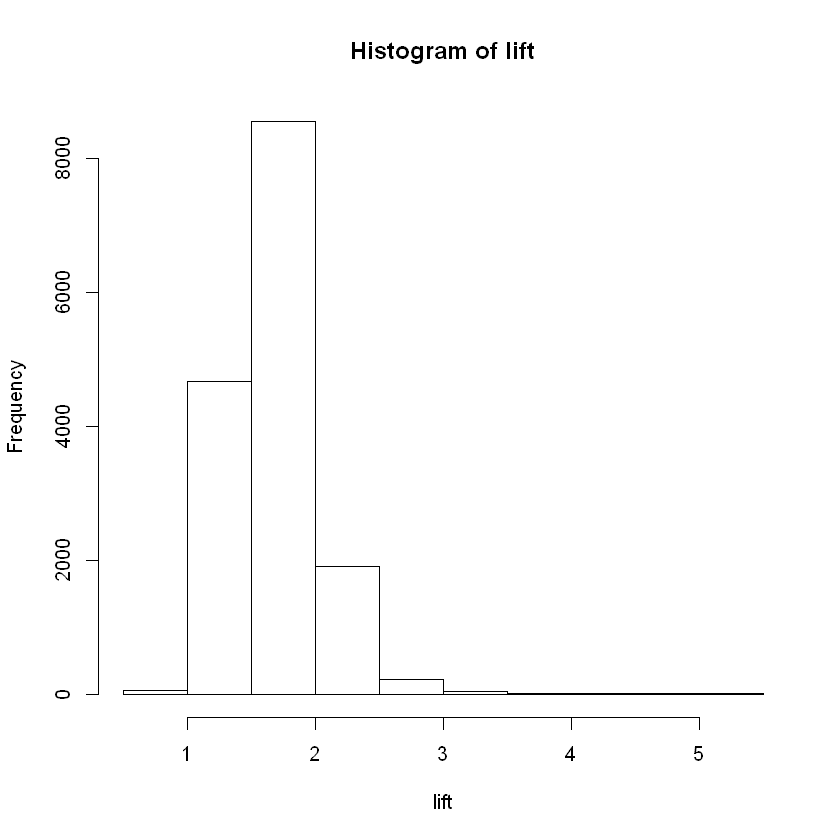

In [8]:
lift<-rules_dt$lift
hist(lift)

In [9]:
filter(rules_dt, lift < 0.831)

lhs,rhs,support,confidence,coverage,lift,count
{packaged produce},{fresh vegetables},0.022880212,0.3689731,0.06201052,0.8308884,73557
"{soft drinks,water seltzer sparkling water}",{packaged vegetables fruits},0.007279912,0.3042839,0.02392473,0.8295445,23404
{soft drinks},{fresh fruits},0.039228287,0.4534322,0.08651412,0.8140222,126114
{energy sports drinks},{fresh fruits},0.010944130,0.4532969,0.02414340,0.8137794,35184
{energy sports drinks},{packaged vegetables fruits},0.007106033,0.2943261,0.02414340,0.8023971,22845
{soft drinks},{packaged vegetables fruits},0.024726319,0.2858067,0.08651412,0.7791716,79492
{breakfast bars pastries},{fresh vegetables},0.006228549,0.3380548,0.01842467,0.7612637,20024
{soft drinks},{fresh vegetables},0.027825041,0.3216243,0.08651412,0.7242638,89454
"{soft drinks,water seltzer sparkling water}",{fresh vegetables},0.007477431,0.3125398,0.02392473,0.7038066,24039
{energy sports drinks},{fresh vegetables},0.007229832,0.2994537,0.02414340,0.6743381,23243


In [10]:
filter(rules_dt, lift > 1.68 & lift < 1.7)

lhs,rhs,support,confidence,coverage,lift,count
"{packaged cheese,pasta sauce,yogurt}",{fresh vegetables},0.008889929,0.7548266,0.011777444,1.699790,28580
"{butter,chips pretzels,fresh vegetables}",{packaged vegetables fruits},0.006268675,0.6234879,0.010054204,1.699764,20153
"{cookies cakes,fresh fruits,fresh vegetables}",{packaged vegetables fruits},0.011406357,0.6234804,0.018294652,1.699744,36670
"{nuts seeds dried fruit,packaged cheese,packaged vegetables fruits}",{milk},0.006076443,0.4155499,0.014622657,1.699698,19535
"{cereal,water seltzer sparkling water}",{milk},0.008306391,0.4155424,0.019989275,1.699667,26704
"{soy lactosefree,spreads,yogurt}",{packaged vegetables fruits},0.005269569,0.6234497,0.008452275,1.699660,16941
"{soft drinks,water seltzer sparkling water}",{chips pretzels},0.006805554,0.2844569,0.023924732,1.699637,21879
"{fresh fruits,packaged vegetables fruits,tortillas flat bread}",{soy lactosefree},0.006649716,0.2884981,0.023049426,1.699581,21378
"{lunch meat,packaged cheese}",{yogurt},0.020046198,0.4478153,0.044764429,1.699566,64446
"{fresh fruits,refrigerated,soy lactosefree}",{bread},0.006302580,0.2786649,0.022617061,1.699532,20262


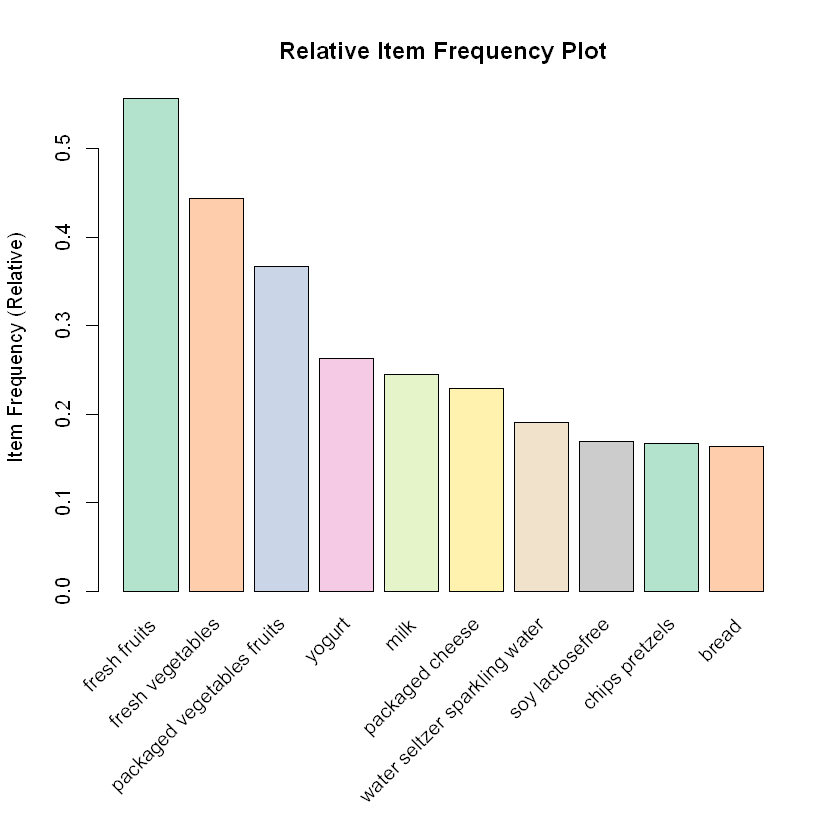

In [25]:
library("RColorBrewer")

#options(repr.plot.width = 5, repr.plot.height = 0.75, repr.plot.res = 100)

arules::itemFrequencyPlot(transactions,
                          topN=10,
                          col=brewer.pal(8,'Pastel2'),
                          main='Relative Item Frequency Plot',
                          type="relative",
                          ylab="Item Frequency (Relative)") 

**Low impact**

In [38]:
# subset rules lift > 1.68 & lift < 1.7
sub.rules1 <- subset(rules, subset = lift < 1 ) # > 1.68 & lift < 1.7
#View(sub.rules)

In [24]:
sub.rules1

set of 56 rules 

In [40]:
range(sub.rules1@quality$lift)

[1] 0.6743381 0.9994034

Warning message:
"Unknown control parameters: type"

Available control parameters (with default values):
main	 =  Graph for 10 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

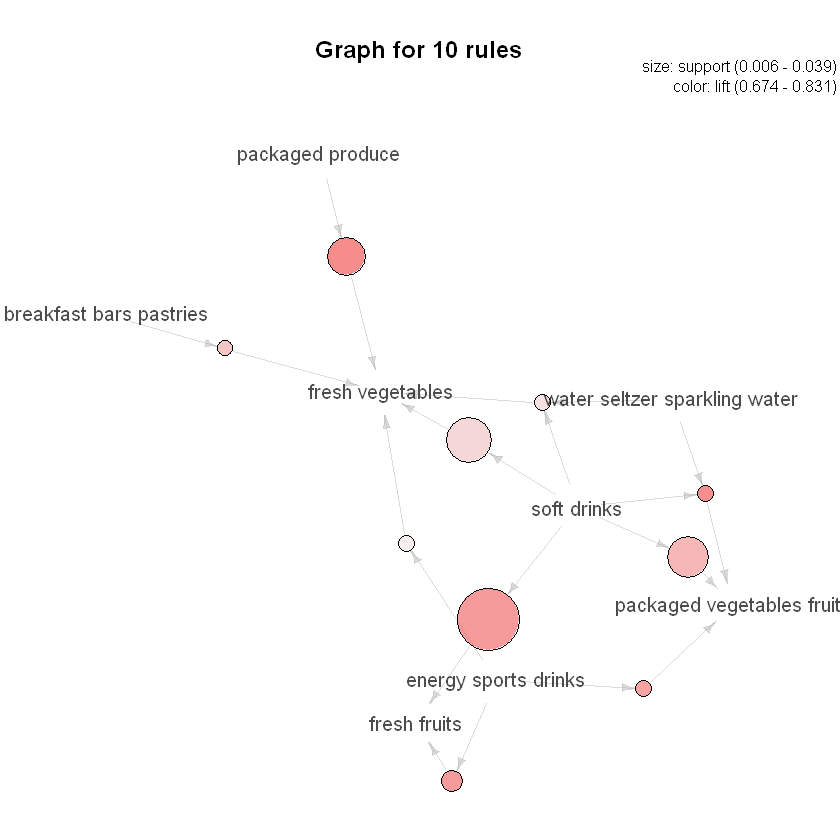

In [41]:
#low impact cases
subrules_x <- head(sort(sub.rules1, by="lift",decreasing = FALSE),10)
ig <- plot( subrules_x, method="graph", control=list(type="items") )

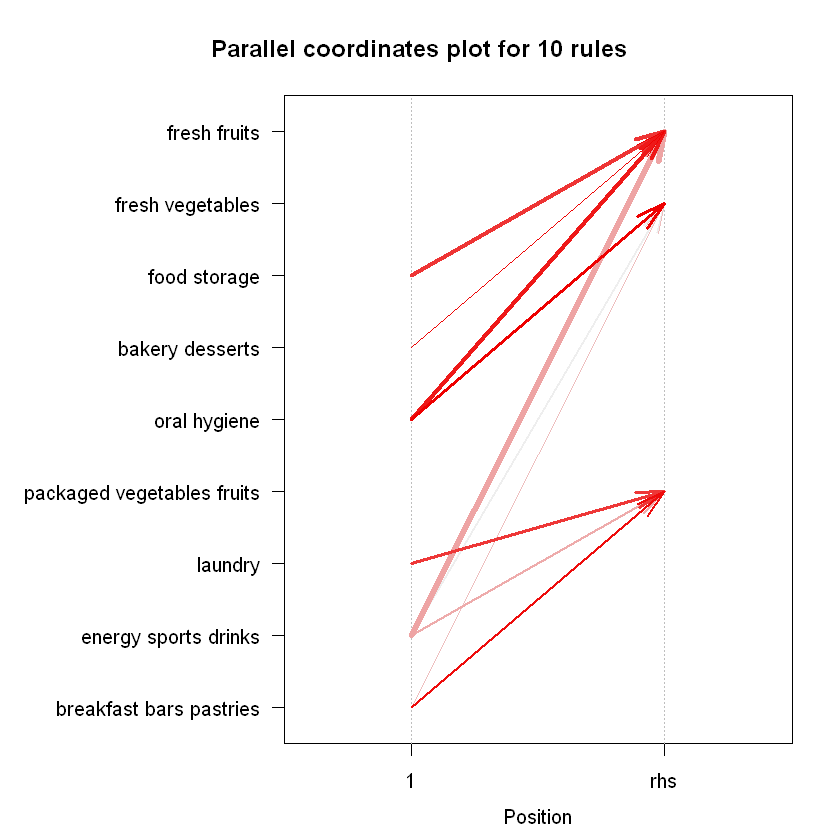

In [33]:
plot(sub.rules1[1:10],method = "paracoord",control = list(reorder = TRUE))

In [48]:
data.table( lhs = labels( lhs(subrules_x) ), 
                        rhs = labels( rhs(subrules_x) ), 
                        quality(subrules_x) )[ order(-lift), ] 


lhs,rhs,support,confidence,coverage,lift,count
{packaged produce},{fresh vegetables},0.022880212,0.3689731,0.06201052,0.8308884,73557
"{soft drinks,water seltzer sparkling water}",{packaged vegetables fruits},0.007279912,0.3042839,0.02392473,0.8295445,23404
{soft drinks},{fresh fruits},0.039228287,0.4534322,0.08651412,0.8140222,126114
{energy sports drinks},{fresh fruits},0.010944130,0.4532969,0.02414340,0.8137794,35184
{energy sports drinks},{packaged vegetables fruits},0.007106033,0.2943261,0.02414340,0.8023971,22845
{soft drinks},{packaged vegetables fruits},0.024726319,0.2858067,0.08651412,0.7791716,79492
{breakfast bars pastries},{fresh vegetables},0.006228549,0.3380548,0.01842467,0.7612637,20024
{soft drinks},{fresh vegetables},0.027825041,0.3216243,0.08651412,0.7242638,89454
"{soft drinks,water seltzer sparkling water}",{fresh vegetables},0.007477431,0.3125398,0.02392473,0.7038066,24039
{energy sports drinks},{fresh vegetables},0.007229832,0.2994537,0.02414340,0.6743381,23243


**Medium Impact**

In [43]:
sub.rules2 <- subset(rules, subset = lift > 1 & lift < 2 )

Warning message:
"Unknown control parameters: type"

Available control parameters (with default values):
main	 =  Graph for 10 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

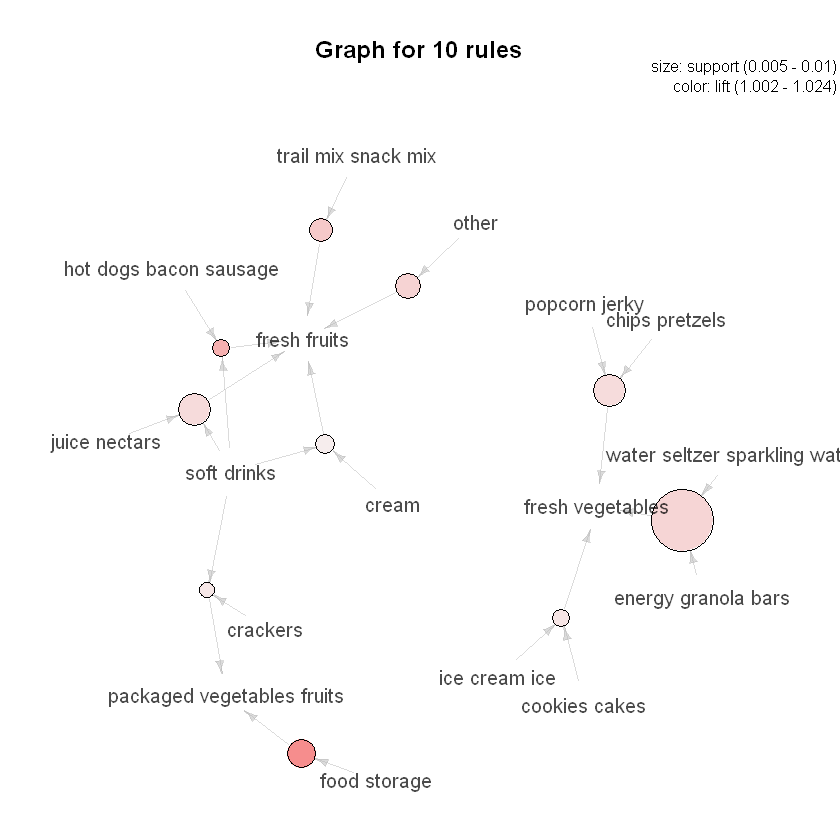

In [44]:
#medium impact cases
subrules_2 <- head(sort(sub.rules2, by="lift",decreasing = FALSE),10)
ig <- plot( subrules_2, method="graph", control=list(type="items") )

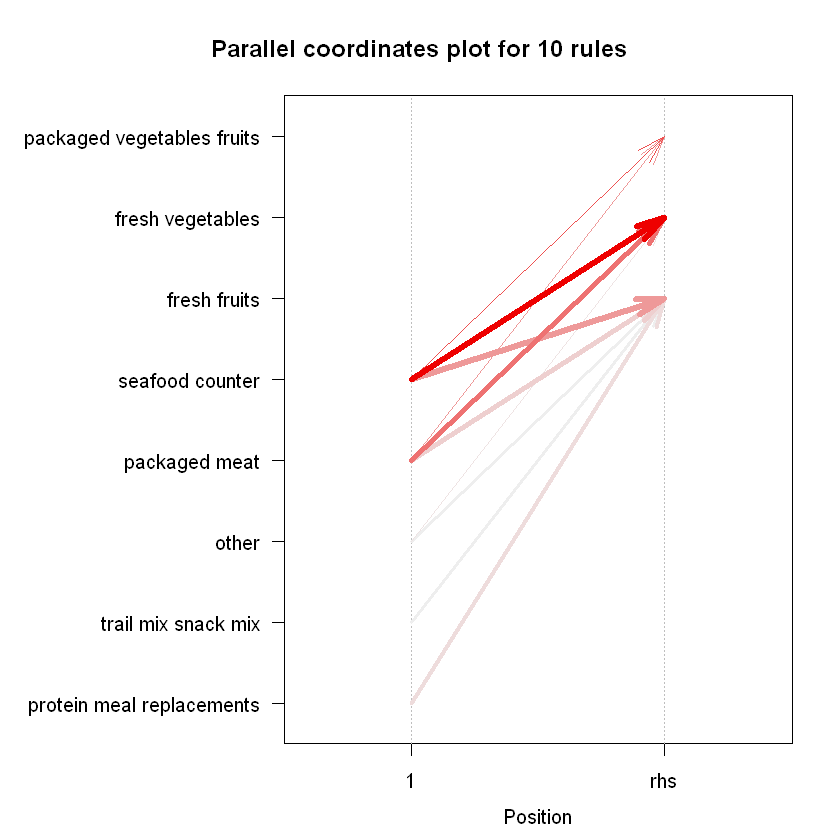

In [45]:
plot(sub.rules2[1:10],method = "paracoord",control = list(reorder = TRUE))

In [50]:
head(data.table( lhs = labels( lhs(sub.rules2) ), 
                        rhs = labels( rhs(sub.rules2) ), 
                        quality(sub.rules2) )[ order(-lift), ],10 )

lhs,rhs,support,confidence,coverage,lift,count
"{fruit vegetable snacks,yogurt}",{packaged cheese},0.008659437,0.4590410,0.018864192,1.999947,27839
"{canned jarred vegetables,fresh fruits,oils vinegars}",{fresh vegetables},0.005977217,0.8881083,0.006730279,1.999926,19216
"{fresh vegetables,frozen appetizers sides,milk}",{yogurt},0.005571914,0.5269149,0.010574598,1.999768,17913
"{buns rolls,packaged vegetables fruits}",{packaged cheese},0.006615500,0.4589853,0.014413318,1.999704,21268
"{chips pretzels,fresh fruits,yogurt}",{packaged cheese},0.019736699,0.4589684,0.043002307,1.999631,63451
"{cream,fresh vegetables,packaged cheese}",{eggs},0.005059296,0.2739276,0.018469464,1.999598,16265
"{frozen meals,packaged cheese}",{chips pretzels},0.008084298,0.3346553,0.024157090,1.999574,25990
"{packaged vegetables fruits,spreads}",{bread},0.011878537,0.3278334,0.036233457,1.999402,38188
"{milk,packaged cheese,packaged vegetables fruits}",{eggs},0.011900311,0.2738916,0.043448981,1.999335,38258
"{juice nectars,packaged cheese,yogurt}",{milk},0.005818580,0.4887774,0.011904355,1.999216,18706


In [ ]:
#fruit veg snacks (veggie straws) - 18$ for 24 count
#yogurt - 4$
#cheese - 5$

#all these 3 for 



**Calculating impact**

In [54]:
sum(rules_dt[rules_dt$lhs == '{fruit vegetable snacks,yogurt}']$count)

[1] 281723

Assuming prices of following:

    - Veggie straws: 18$
- cheese : 5$
    - Yogurt : 4$

These 3 have been bought together 27839 times which comes out to be around : 27839 * 27$ = 751,653

Total no of transactions in which Veggie straws and yogurt are being bought together: 281723

Subtracting from above: 281723 - 27839 = 253,884

In case we start promoting cheese along with it or place it next to them, we may end up say 10% of the customers buying this

So additional customers who may buy cheese along with other two products: 0.1 * 253,884 = 25,388

So the additional profit we will be making through reccomendation: 25,388 * 5$ = 126,940$


**High impact**

In [30]:
sub.rules3 <- subset(rules, subset = lift >= 2)

Warning message:
"Unknown control parameters: type"

Available control parameters (with default values):
main	 =  Graph for 10 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

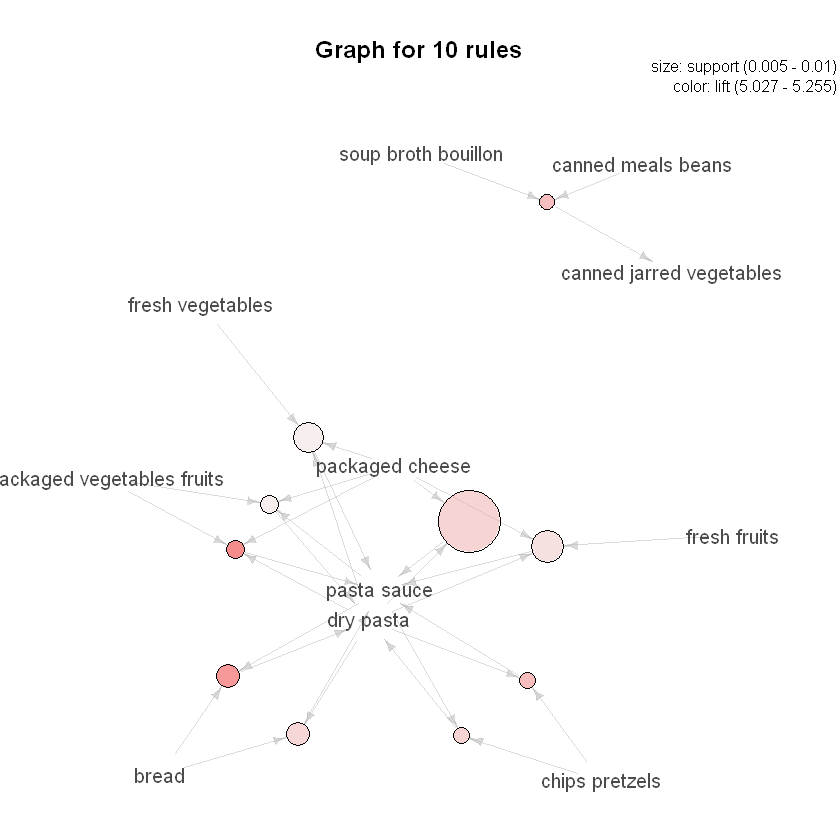

In [42]:
#medium impact cases
subrules_3 <- head(sort(sub.rules3, by="lift",decreasing = TRUE),10)
ig <- plot( subrules_3, method="graph", control=list(type="items") )

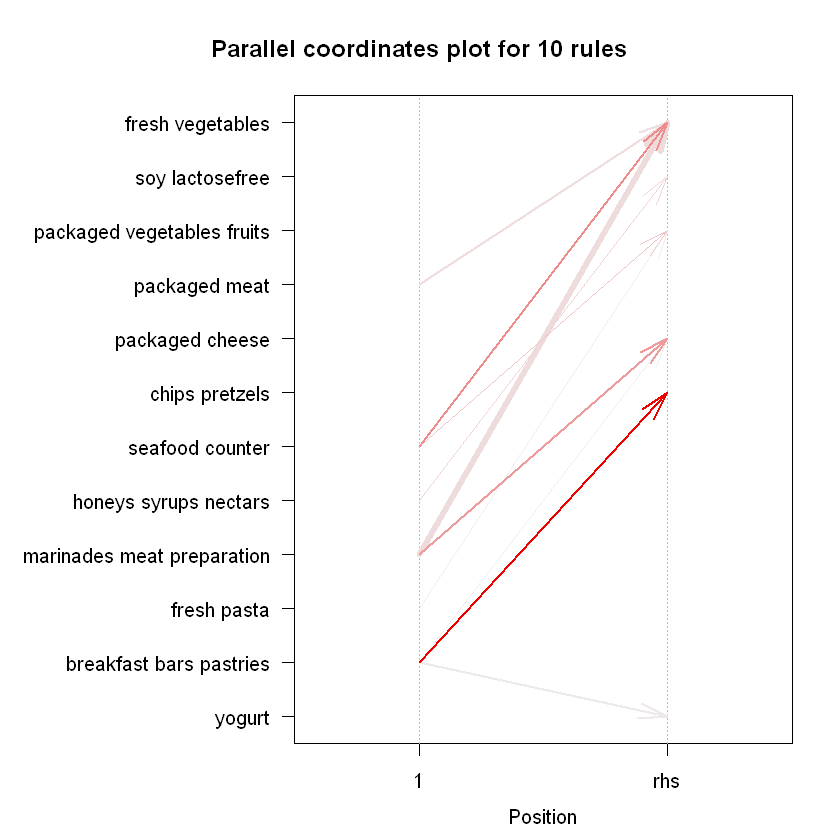

In [35]:
plot(sub.rules3[1:10],method = "paracoord",control = list(reorder = TRUE))

In [51]:
head(data.table( lhs = labels( lhs(sub.rules3) ), 
                        rhs = labels( rhs(sub.rules3) ), 
                        quality(sub.rules3) )[ order(-lift), ],10 )

lhs,rhs,support,confidence,coverage,lift,count
"{dry pasta,packaged cheese,packaged vegetables fruits}",{pasta sauce},0.005669896,0.3257560,0.01740535,5.255267,18228
"{bread,pasta sauce}",{dry pasta},0.006127456,0.3699621,0.01656239,5.236959,19699
"{chips pretzels,dry pasta}",{pasta sauce},0.005523078,0.3202626,0.01724547,5.166646,17756
"{canned meals beans,soup broth bouillon}",{canned jarred vegetables},0.005388081,0.3800685,0.01417661,5.164972,17322
"{chips pretzels,pasta sauce}",{dry pasta},0.005523078,0.3613276,0.01528551,5.114735,17756
"{dry pasta,packaged cheese}",{pasta sauce},0.009534744,0.3168269,0.03009449,5.111218,30653
"{bread,dry pasta}",{pasta sauce},0.006127456,0.3163431,0.01936965,5.103414,19699
"{dry pasta,fresh fruits,packaged cheese}",{pasta sauce},0.006954549,0.3139992,0.02214830,5.065601,22358
"{dry pasta,fresh vegetables,packaged cheese}",{pasta sauce},0.006767606,0.3115933,0.02171936,5.026787,21757
"{packaged cheese,packaged vegetables fruits,pasta sauce}",{dry pasta},0.005669896,0.3551001,0.01596703,5.026582,18228


In [52]:
ig_df <- get.data.frame( ig, what = "both" )
nodesv %>%
  visNodes(size = 10) %>%
  visLegend() %>%
  visEdges(smooth = FALSE) %>%
  visOptions(highlightNearest = TRUE, nodesIdSelection = TRUE) %>%
  visInteraction(navigationButtons = TRUE) %>%
  visEdges(arrows = 'from') %>%
  visPhysics(
    solver = "barnesHut",
    maxVelocity = 35,
    forceAtlas2Based = list(gravitationalConstant = -6000)
  )


ERROR: Error in eval(lhs, parent, parent): object 'nodesv' not found
